In [58]:
# ------ River imports ---------

from river import stream

# Metrics
from river.metrics import Accuracy, Precision, Recall, F1, CohenKappa, BalancedAccuracy

# Drift Detectors
from river.drift import ADWIN, KSWIN, PageHinkley, DriftRetrainingClassifier
from river.drift.binary import *

# Classifiers
from river.linear_model import LogisticRegression
from river.forest import ARFClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier

In [59]:
# ------ Sk-learn imports -------------

# sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Sklearn Metric
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score

# Others
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [60]:
# ------ Basic python lib imports ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import mplcursors
from collections import deque
import warnings
from scipy.stats import ks_2samp

warnings.filterwarnings("ignore")

# %matplotlib inline
# mpld3.enable_notebook()

In [61]:
# ------ Get "cfpdss" data --------------------------
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
df_cfpdss.head()

c5 c6 c7 c8 c9        n0        n1        n2        n3        n4 class
0  a  a  b  a  a  0.448573  1.212644  2.555515  0.242702  0.697604     A
1  a  a  a  b  b  1.902515 -0.467349 -0.744523 -0.017156 -0.380288     A
2  a  a  a  b  b  0.825045  1.002267  1.972207 -0.790095  0.233456     B
3  a  a  a  b  b -0.124974  0.902601  1.696092 -0.320182  0.243261     A
4  b  a  a  b  a -1.259765  0.793134  1.547527 -2.132172 -0.788367     B

In [5]:
# ------ Data pre-processing --------------
X_df = df_cfpdss.drop(columns="class")

# Separating categorical and non-categorical columns
categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
X_df_categorical = X_df[categorical_columns]
non_cat_columns = [col for col in X_df.columns if col not in categorical_columns]
X_df_non_categorical = X_df[non_cat_columns]

# One hot encoding - Categorical data
encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
one_hot_encoded = encoder.fit_transform(X_df_categorical)
columns = encoder.get_feature_names_out()
X_df_cat_one_hot = pd.DataFrame(one_hot_encoded, columns=columns)

# Feature scaling numerical data/non-categorical data
scaler = MinMaxScaler()
X_non_cat_df = pd.DataFrame(
    scaler.fit_transform(X_df_non_categorical), columns=scaler.get_feature_names_out()
)

# Concatenate categorical and non-categorical data
X_df_encoded = pd.concat(
    [
        X_df_cat_one_hot,
        X_non_cat_df,
    ],
    axis=1,
)

# Encoding the target variable
y_df = df_cfpdss[["class"]]
y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
y_one_hot = y_encoder.fit_transform(y_df)
y_encoded = pd.Series(y_one_hot.ravel())

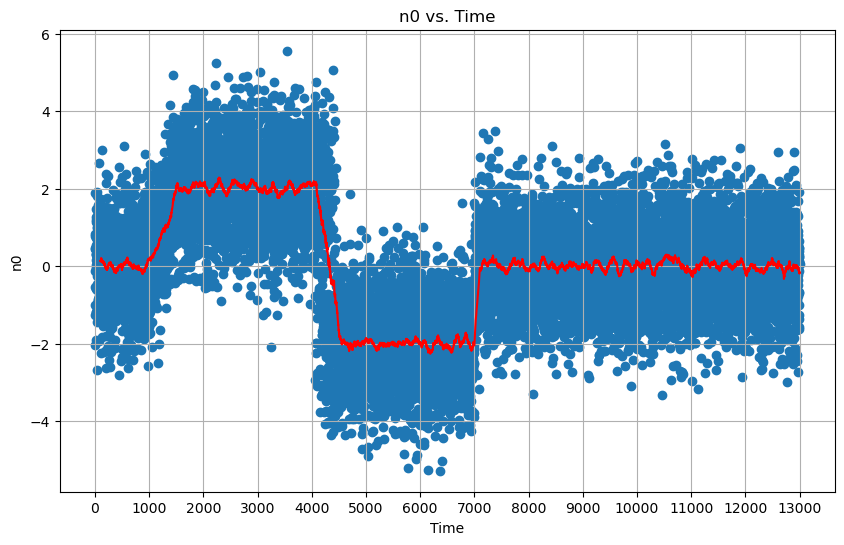

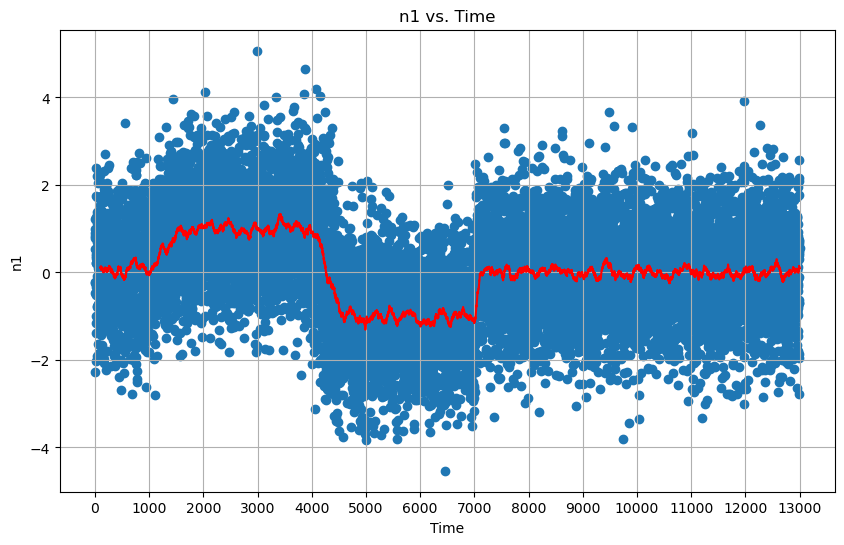

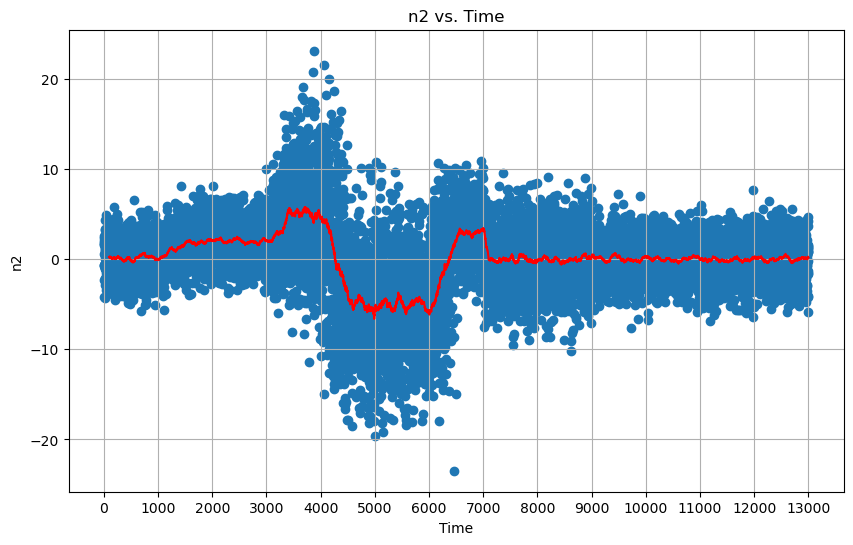

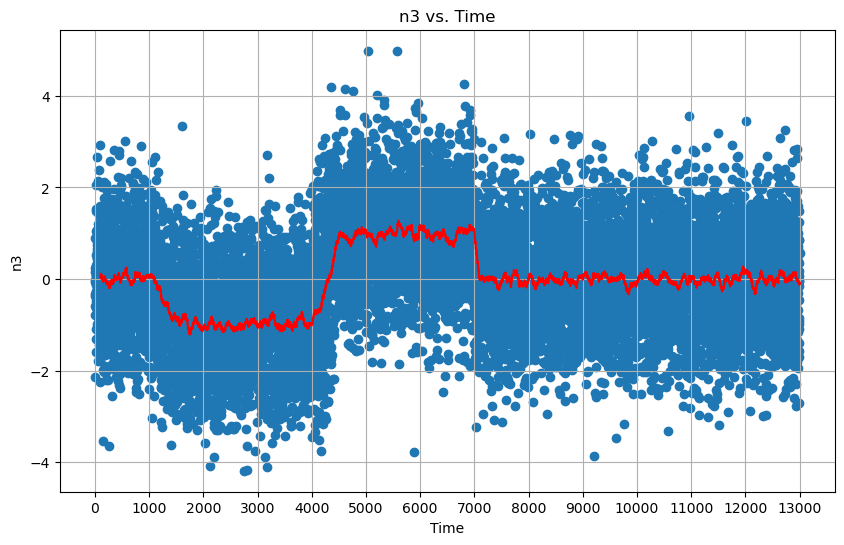

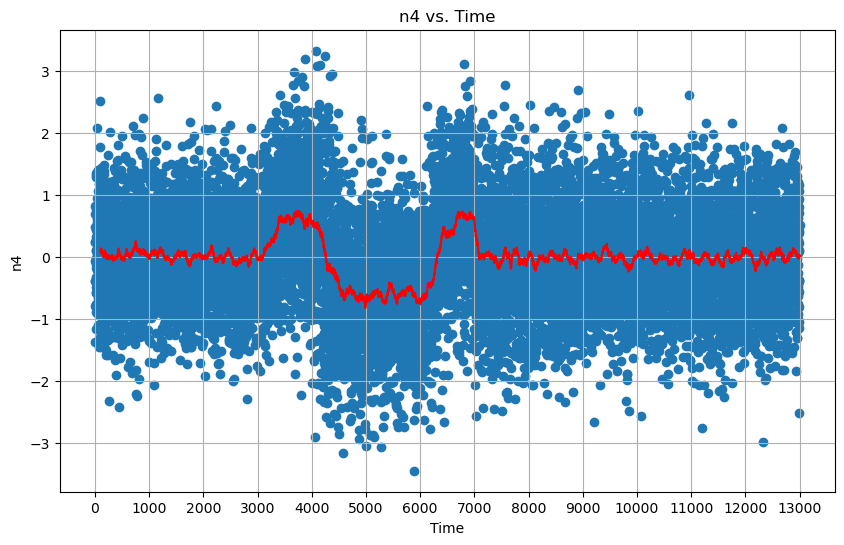

In [6]:
# Moving average plot for each numerical feature with window size 100
window_size = 100
for feature in non_cat_columns:
    # Plotting the line graph
    plt.figure(figsize=(10, 6))  # Optional: specify the size of the plot
    plt.scatter(
        X_df.index,
        X_df[feature],
        marker="o",
    )

    # Calculate the moving mean of the feature
    moving_mean = X_df[feature].rolling(window=window_size).mean()
    # Add a line for the moving mean
    plt.plot(
        X_df.index,
        moving_mean,
        color="red",
        linestyle="-",
        label=f"{feature} Moving Mean",
    )

    plt.title(f"{feature} vs. Time")
    plt.xlabel(f"Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    # plt.yticks(np.arange(-11, 11, 1))
    plt.xticks(np.arange(0, 14000, 1000))
    plt.show()

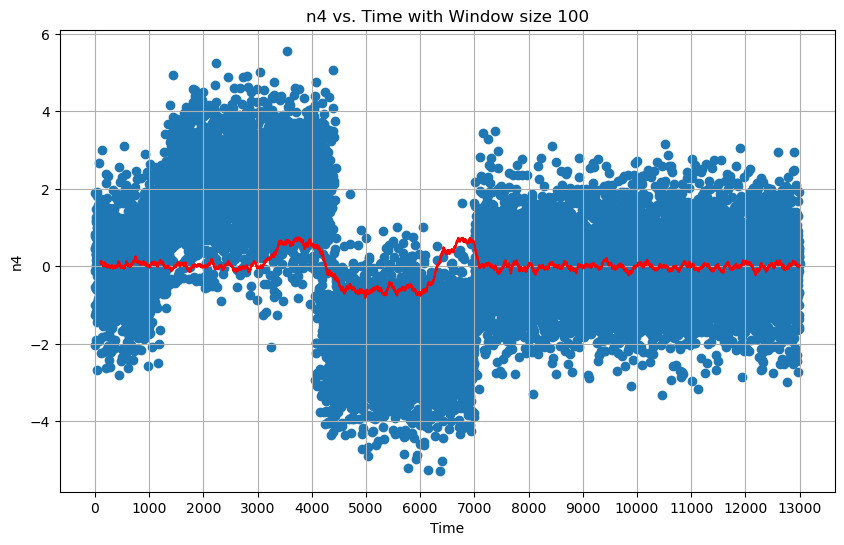

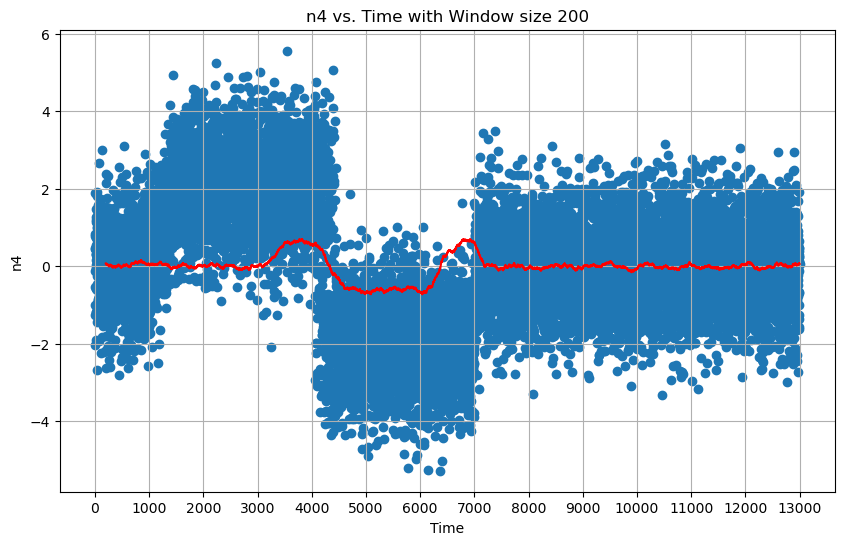

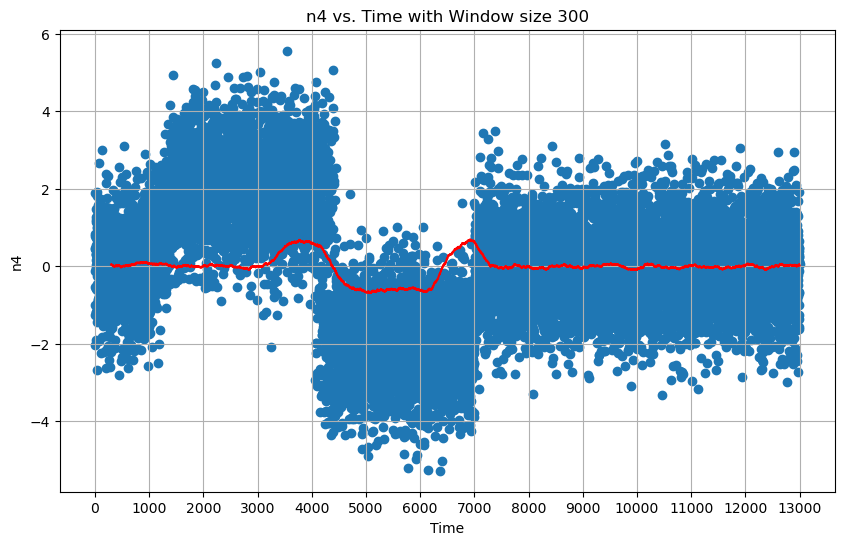

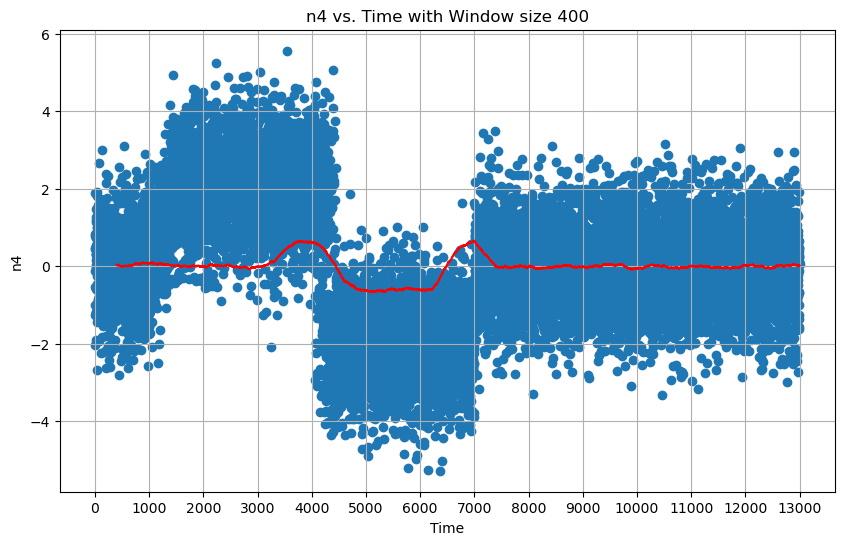

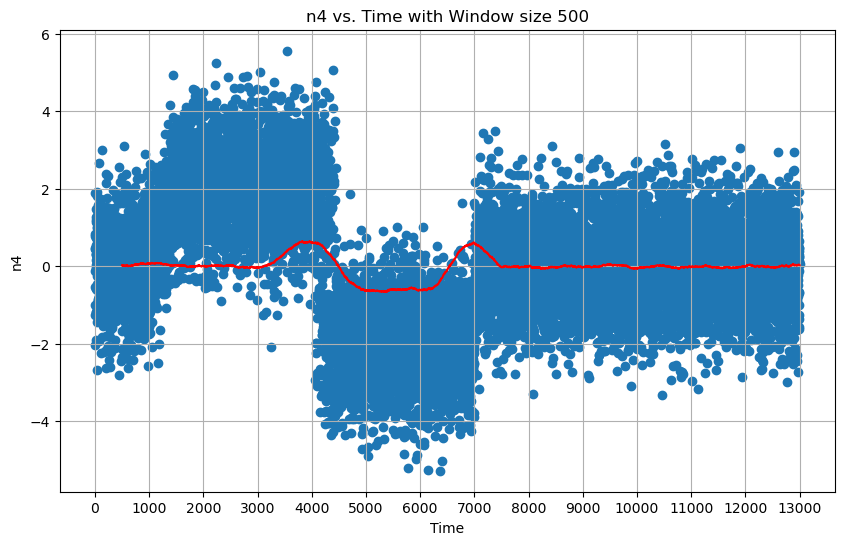

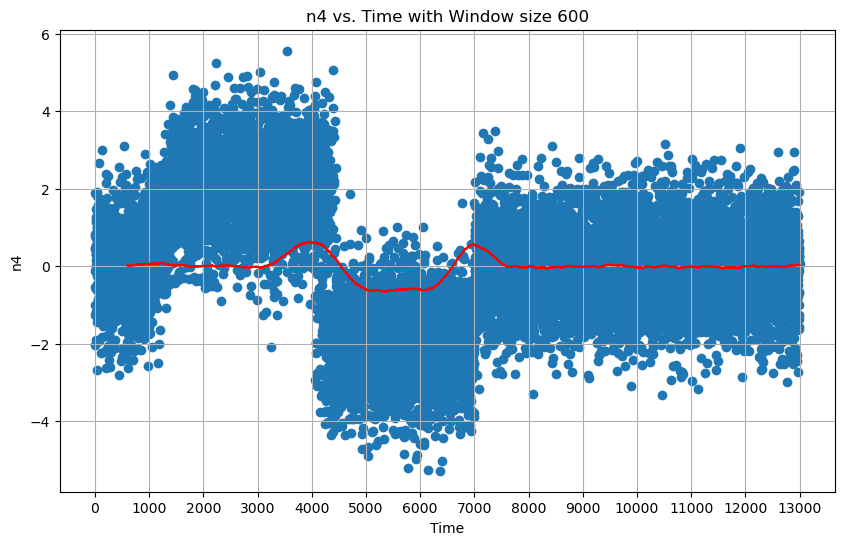

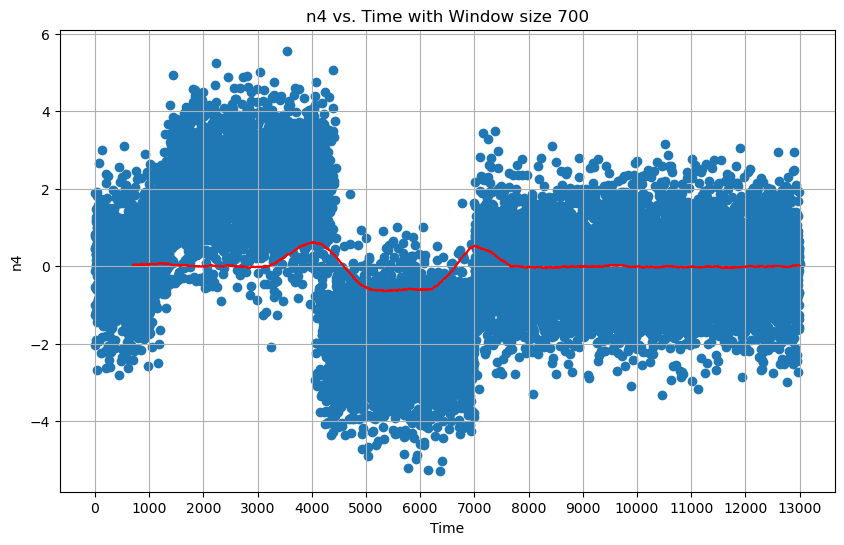

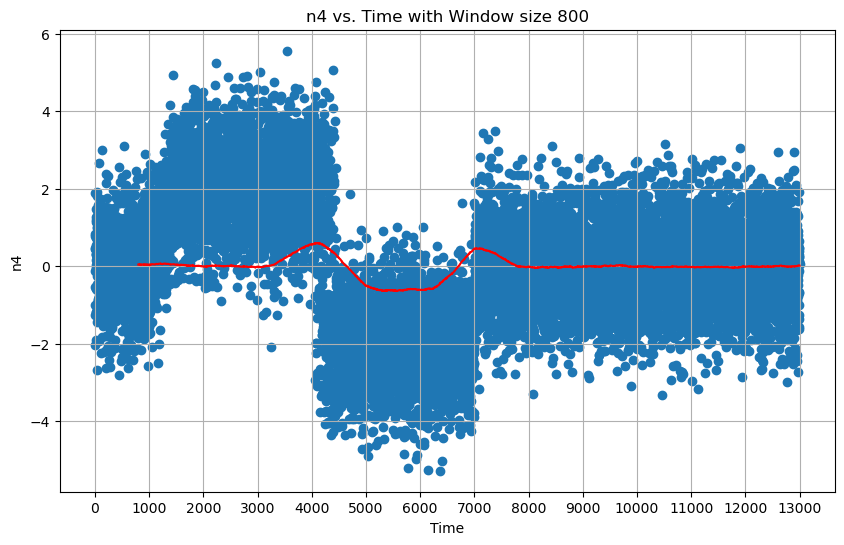

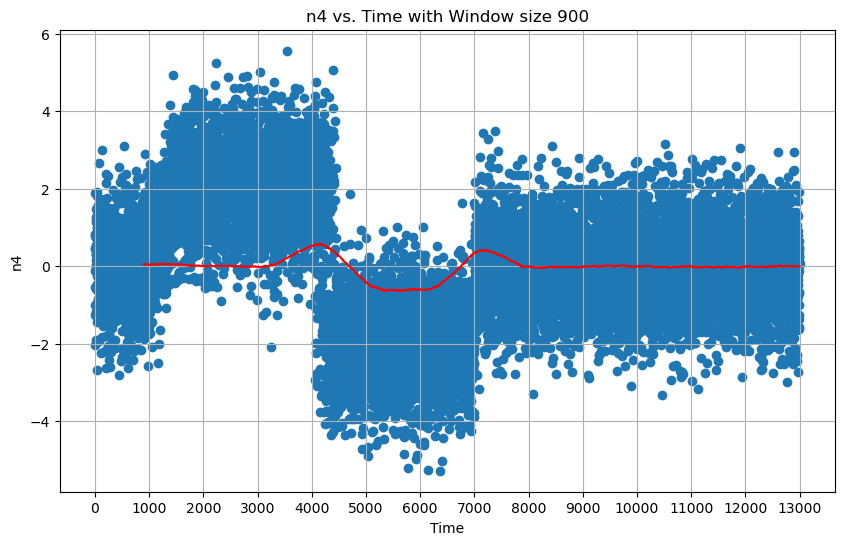

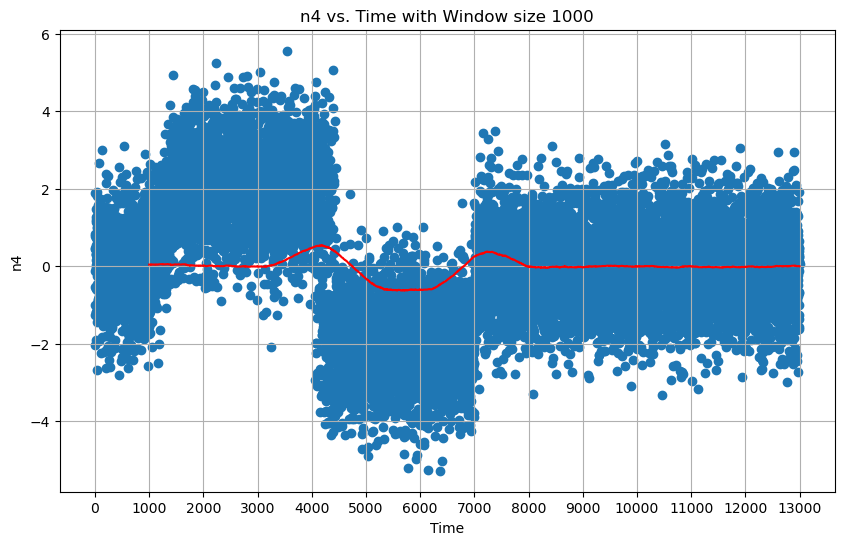

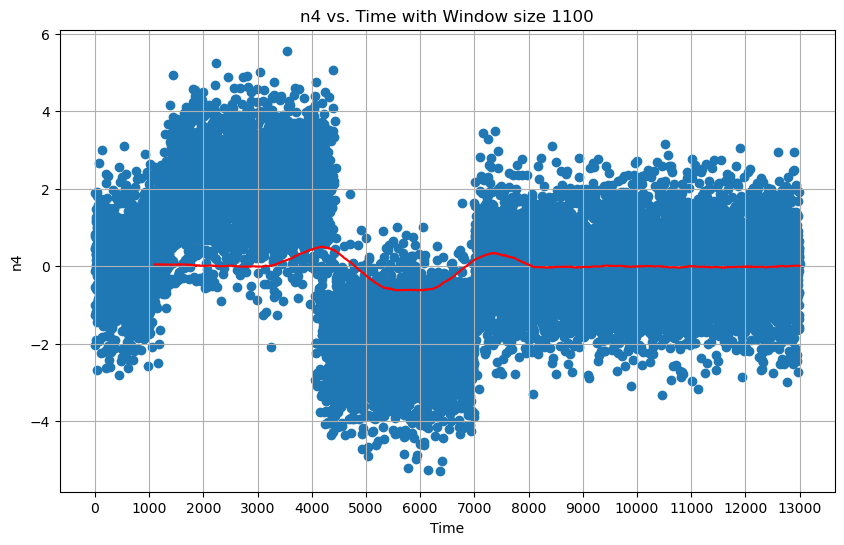

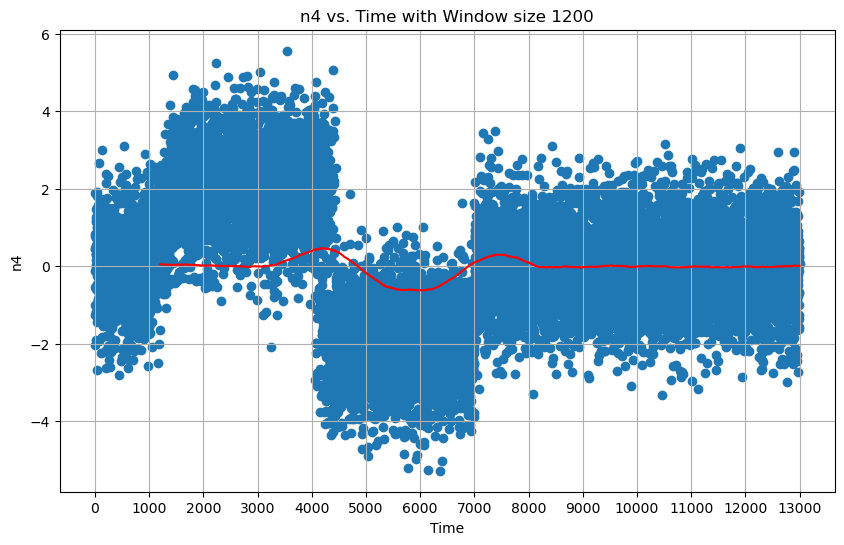

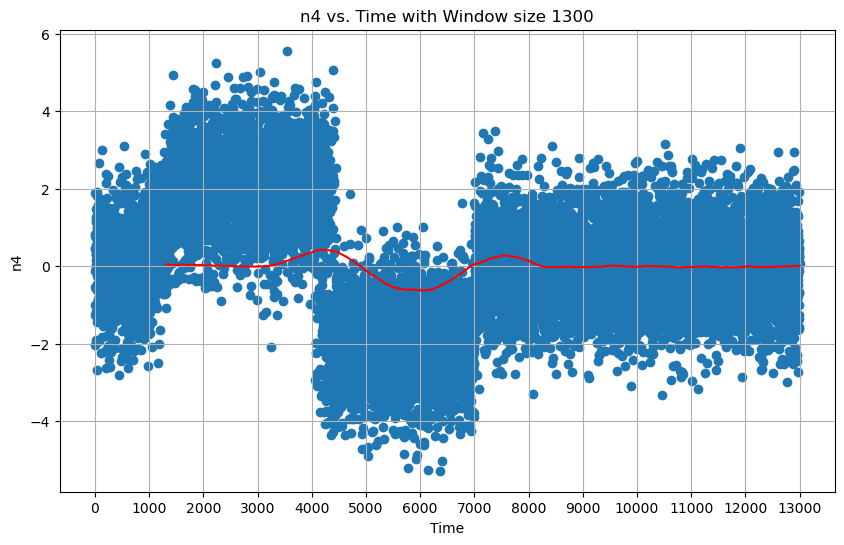

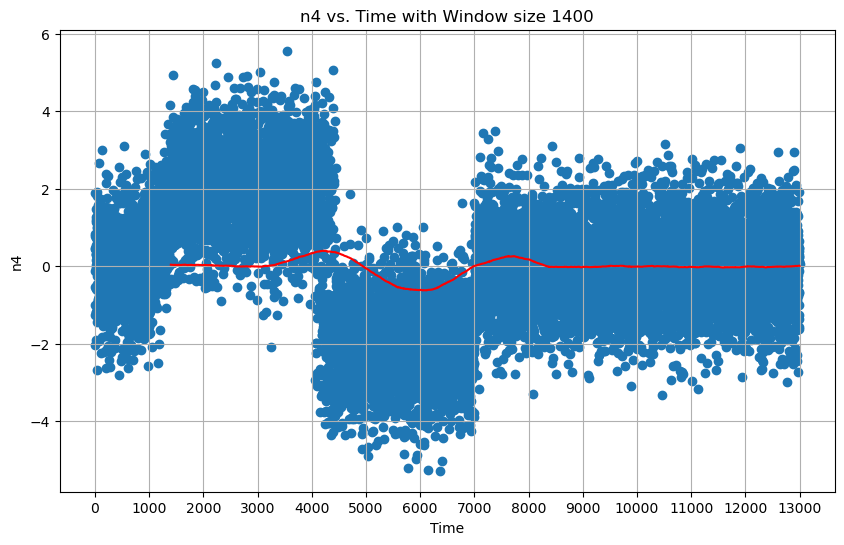

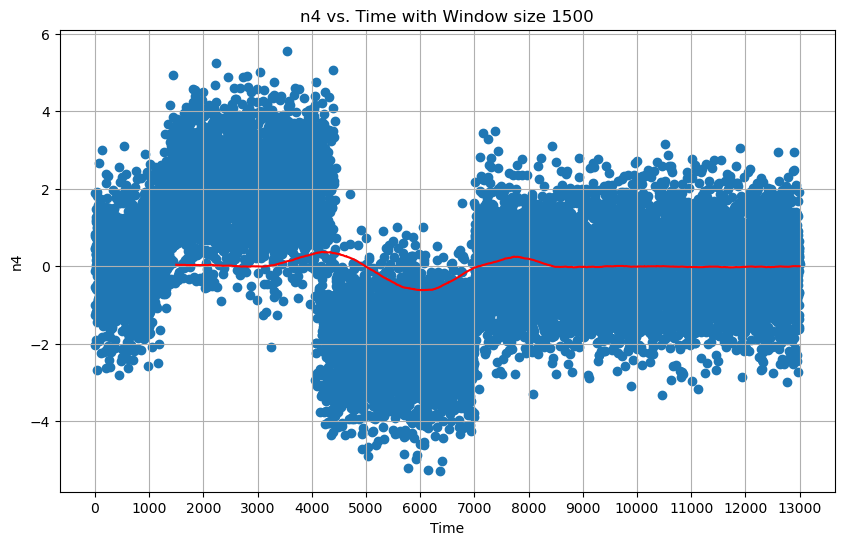

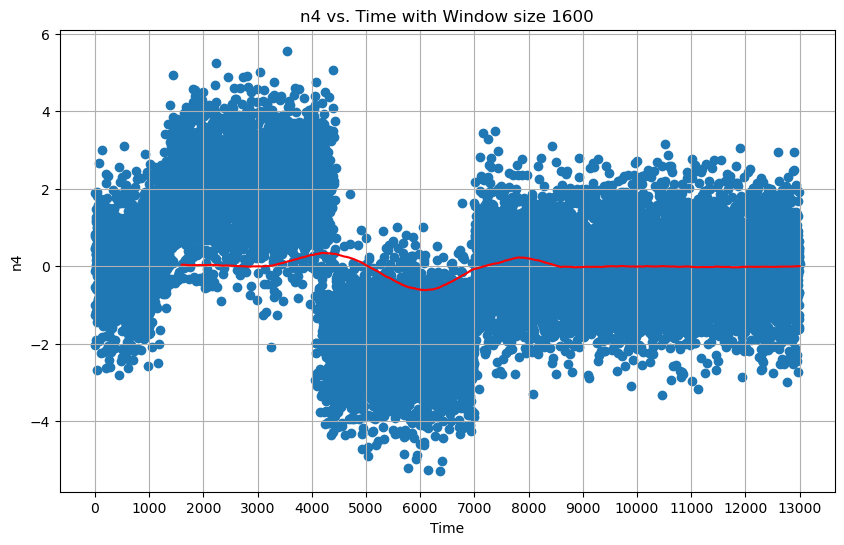

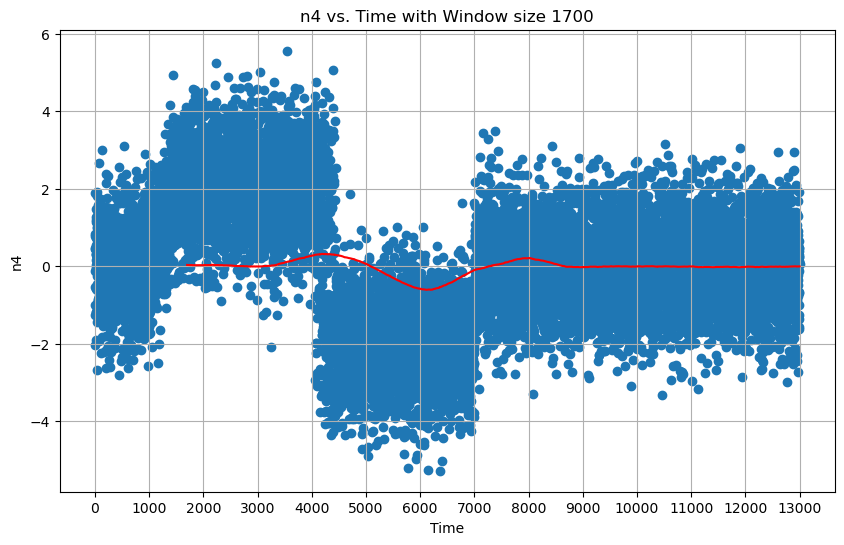

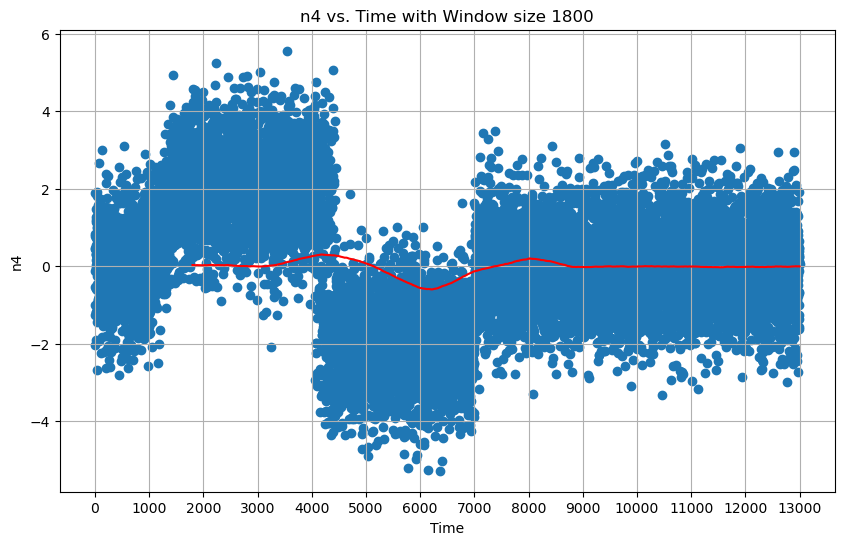

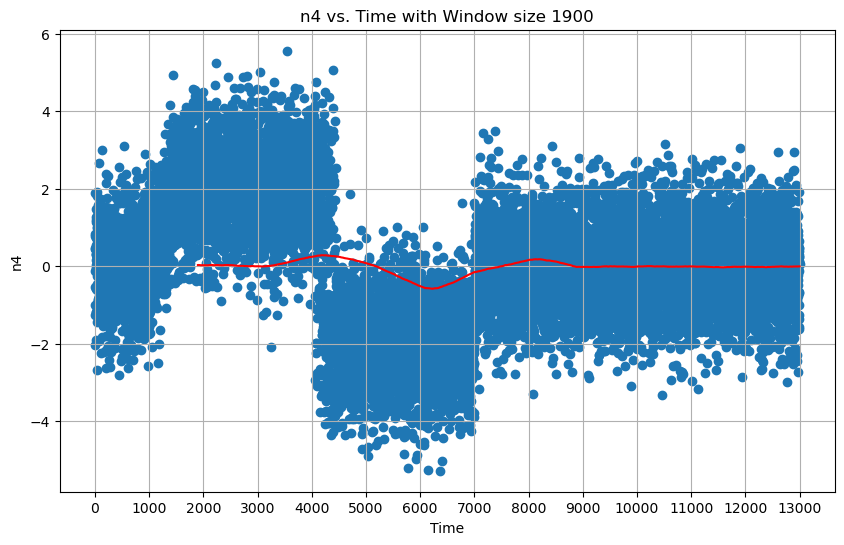

In [7]:
# Moving average plot for a particular feature with varying window size
for window_size in list(range(100, 2000, 100)):
    # Plotting the line graph
    plt.figure(figsize=(10, 6))  # Optional: specify the size of the plot
    plt.scatter(
        X_df.index,
        X_df["n0"],
        marker="o",
    )

    # Calculate the moving mean of the feature
    moving_mean = X_df[feature].rolling(window=window_size).mean()
    # Add a line for the moving mean
    plt.plot(
        X_df.index,
        moving_mean,
        color="red",
        linestyle="-",
        label=f"{feature} Moving Mean",
    )

    plt.title(f"{feature} vs. Time with Window size {window_size}")
    plt.xlabel(f"Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    # plt.yticks(np.arange(-11, 11, 1))
    plt.xticks(np.arange(0, 14000, 1000))
    plt.show()

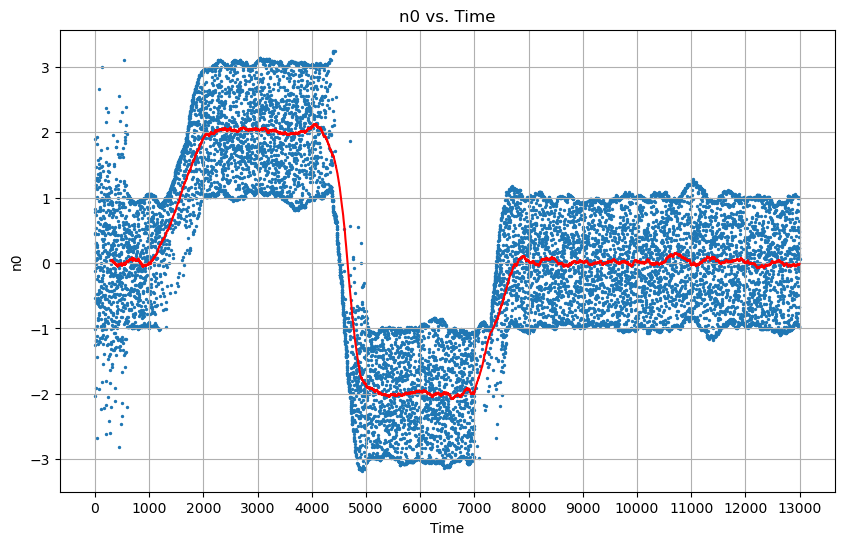

In [20]:
# Moving average plot for a numerical feature with window size 100 with trimming data to 1 stddev
window_size = 300
for feature in non_cat_columns:
    # Plotting the line graph
    plt.figure(figsize=(10, 6))  # Optional: specify the size of the plot
    # plt.scatter(X_df.index, X_df[feature], marker='o', )

    # Calculate the moving mean of the feature
    moving_mean = X_df[feature].rolling(window=window_size).mean()
    # Calculate the moving standard deviation of the feature
    moving_std = X_df[feature].rolling(window=window_size).std()

    # Remove noise by trimming observations to 3 standard deviations within the window
    trimmed_values = X_df[feature].copy()
    for i in range(len(X_df)):
        if i >= window_size:
            mean = moving_mean.iloc[i - window_size]
            std = moving_std.iloc[i - window_size]
            lower_bound = mean - 1 * std
            upper_bound = mean + 1 * std
            if trimmed_values.iloc[i] < lower_bound:
                trimmed_values.iloc[i] = lower_bound
            elif trimmed_values.iloc[i] > upper_bound:
                trimmed_values.iloc[i] = upper_bound

    plt.scatter(X_df.index, trimmed_values, marker="o", s=2)
    # Add a line for the trimmed moving mean
    plt.plot(
        X_df.index,
        trimmed_values.rolling(window=window_size).mean(),
        color="red",
        linestyle="-",
        label=f"{feature} Trimmed Moving Mean",
    )

    plt.title(f"{feature} vs. Time")
    plt.xlabel(f"Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    plt.xticks(np.arange(0, 14000, 1000))
    plt.show()
    break

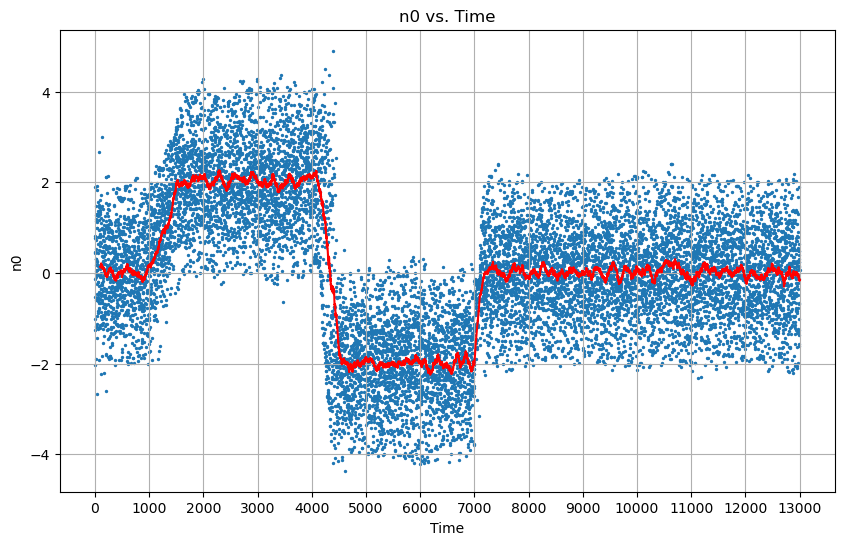

In [8]:
# Moving average plot for a numerical feature with window size 100 with trimming data to 2 stddev
window_size = 100
for feature in non_cat_columns:
    # Plotting the line graph
    plt.figure(figsize=(10, 6))  # Optional: specify the size of the plot
    # plt.scatter(X_df.index, X_df[feature], marker='o', )

    # Calculate the moving mean of the feature
    moving_mean = X_df[feature].rolling(window=window_size).mean()
    # Calculate the moving standard deviation of the feature
    moving_std = X_df[feature].rolling(window=window_size).std()

    # Remove noise by trimming observations to 3 standard deviations within the window
    trimmed_values = X_df[feature].copy()
    for i in range(len(X_df)):
        if i >= window_size:
            mean = moving_mean.iloc[i - window_size]
            std = moving_std.iloc[i - window_size]
            lower_bound = mean - 2 * std
            upper_bound = mean + 2 * std
            if trimmed_values.iloc[i] < lower_bound:
                trimmed_values.iloc[i] = lower_bound
            elif trimmed_values.iloc[i] > upper_bound:
                trimmed_values.iloc[i] = upper_bound

    plt.scatter(X_df.index, trimmed_values, marker="o", s=2)
    # Add a line for the trimmed moving mean
    plt.plot(
        X_df.index,
        trimmed_values.rolling(window=window_size).mean(),
        color="red",
        linestyle="-",
        label=f"{feature} Trimmed Moving Mean",
    )

    plt.title(f"{feature} vs. Time")
    plt.xlabel(f"Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    plt.xticks(np.arange(0, 14000, 1000))
    plt.show()
    break

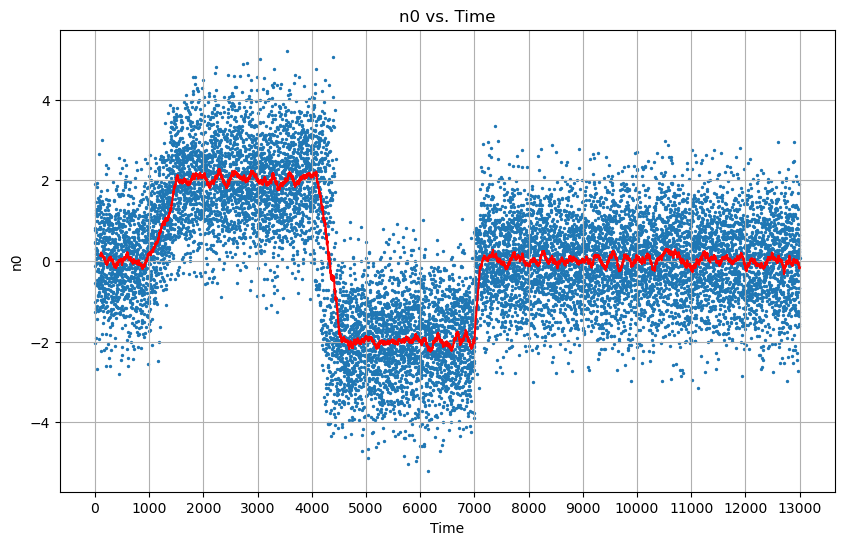

In [9]:
# Moving average plot for a numerical feature with window size 100 with trimming data to 3 stddev
window_size = 100
for feature in non_cat_columns:
    # Plotting the line graph
    plt.figure(figsize=(10, 6))  # Optional: specify the size of the plot
    # plt.scatter(X_df.index, X_df[feature], marker='o', )

    # Calculate the moving mean of the feature
    moving_mean = X_df[feature].rolling(window=window_size).mean()
    # Calculate the moving standard deviation of the feature
    moving_std = X_df[feature].rolling(window=window_size).std()

    # Remove noise by trimming observations to 3 standard deviations within the window
    trimmed_values = X_df[feature].copy()
    for i in range(len(X_df)):
        if i >= window_size:
            mean = moving_mean.iloc[i - window_size]
            std = moving_std.iloc[i - window_size]
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std
            if trimmed_values.iloc[i] < lower_bound:
                trimmed_values.iloc[i] = lower_bound
            elif trimmed_values.iloc[i] > upper_bound:
                trimmed_values.iloc[i] = upper_bound

    plt.scatter(X_df.index, trimmed_values, marker="o", s=2)
    # Add a line for the trimmed moving mean
    plt.plot(
        X_df.index,
        trimmed_values.rolling(window=window_size).mean(),
        color="red",
        linestyle="-",
        label=f"{feature} Trimmed Moving Mean",
    )

    plt.title(f"{feature} vs. Time")
    plt.xlabel(f"Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    plt.xticks(np.arange(0, 14000, 1000))
    plt.show()
    break

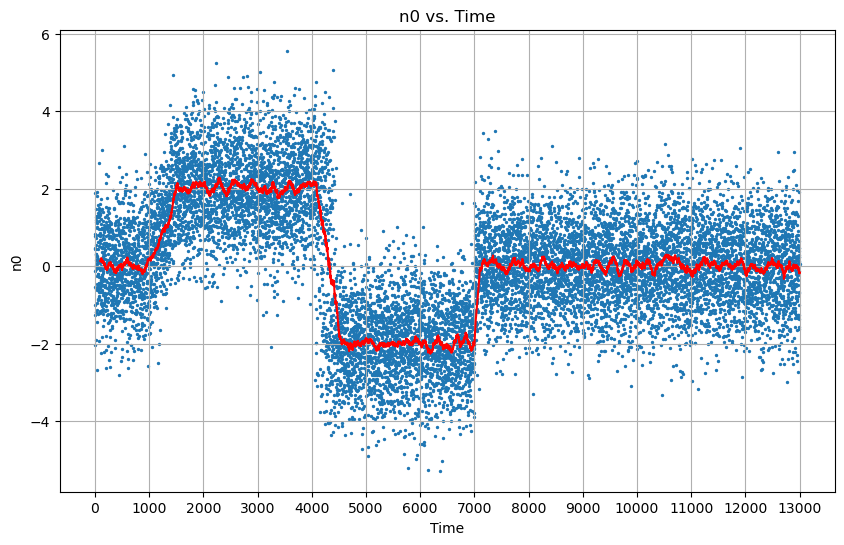

In [10]:
# Moving average plot for a numerical feature with window size 100 without
window_size = 100
for feature in non_cat_columns:
    # Plotting the line graph
    plt.figure(figsize=(10, 6))  # Optional: specify the size of the plot
    plt.scatter(X_df.index, X_df[feature], marker="o", s=2)

    # Calculate the moving mean of the feature
    moving_mean = X_df[feature].rolling(window=window_size).mean()
    # Add a line for the moving mean
    plt.plot(
        X_df.index,
        moving_mean,
        color="red",
        linestyle="-",
        label=f"{feature} Moving Mean",
    )

    plt.title(f"{feature} vs. Time")
    plt.xlabel(f"Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    # plt.yticks(np.arange(-11, 11, 1))
    plt.xticks(np.arange(0, 14000, 1000))
    plt.show()
    break

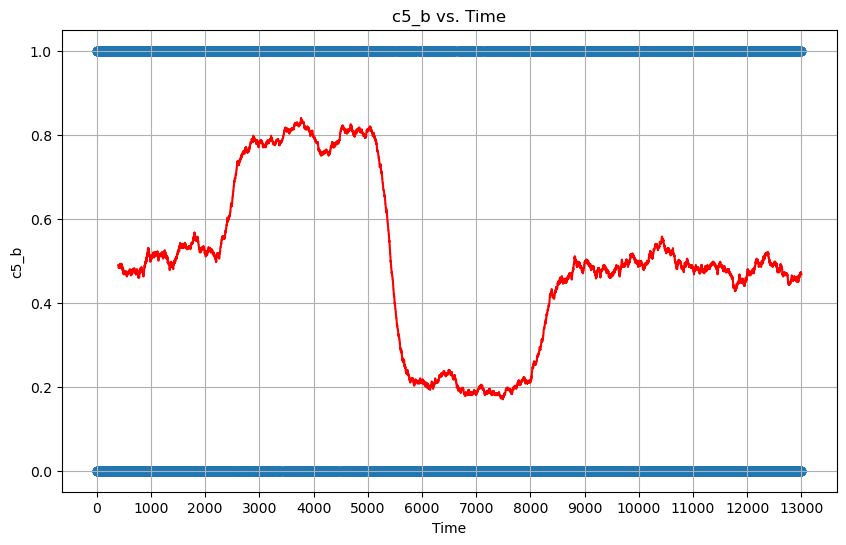

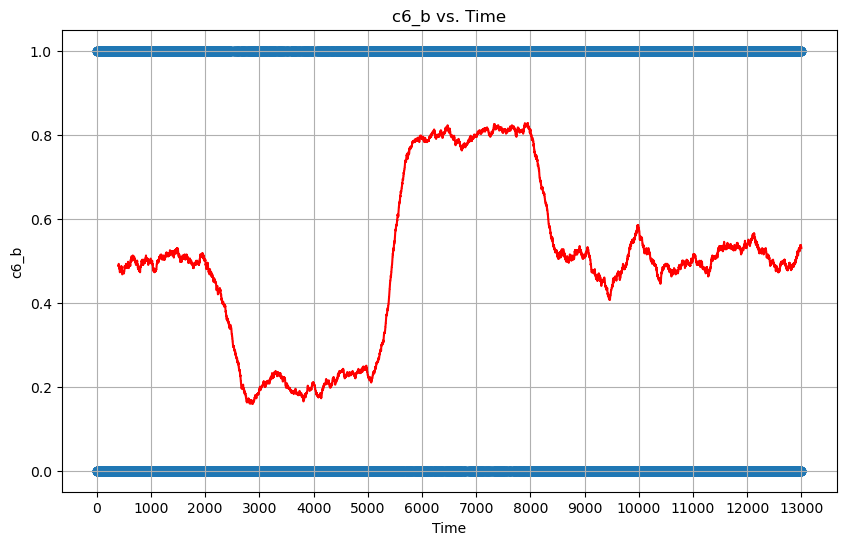

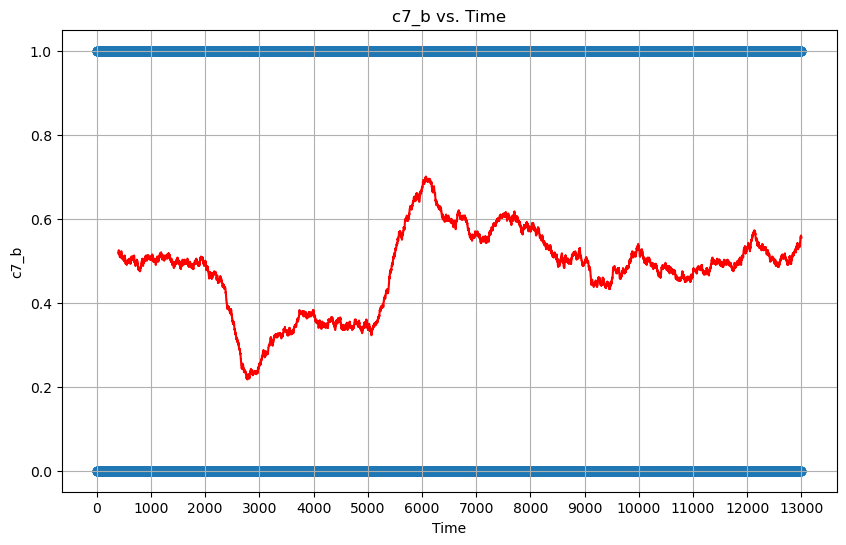

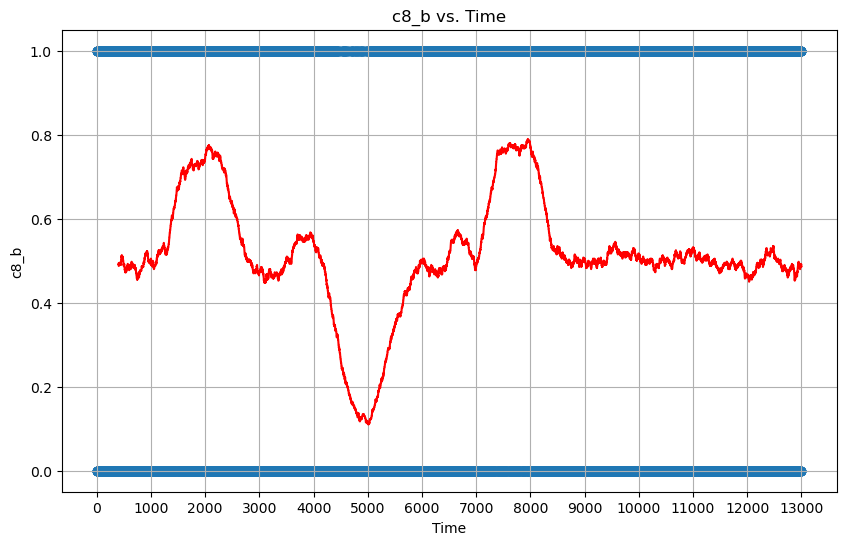

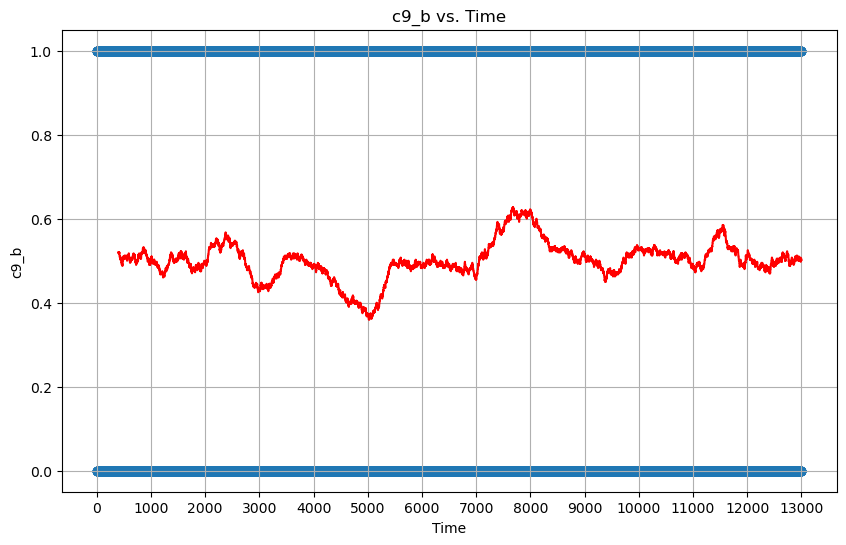

In [11]:
# Moving average plot for each categorical feature with window size 100
window_size = 400
for feature in X_df_cat_one_hot.columns:
    # Plotting the line graph
    plt.figure(figsize=(10, 6))  # Optional: specify the size of the plot
    plt.scatter(
        X_df_cat_one_hot.index,
        X_df_cat_one_hot[feature],
        marker="o",
    )

    # Calculate the moving mean of the feature
    moving_mean = X_df_cat_one_hot[feature].rolling(window=window_size).mean()
    # Add a line for the moving mean
    plt.plot(
        X_df_cat_one_hot.index,
        moving_mean,
        color="red",
        linestyle="-",
        label=f"{feature} Moving Mean",
    )

    plt.title(f"{feature} vs. Time")
    plt.xlabel(f"Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    # plt.yticks(np.arange(-11, 11, 1))
    plt.xticks(np.arange(0, 14000, 1000))
    plt.show()

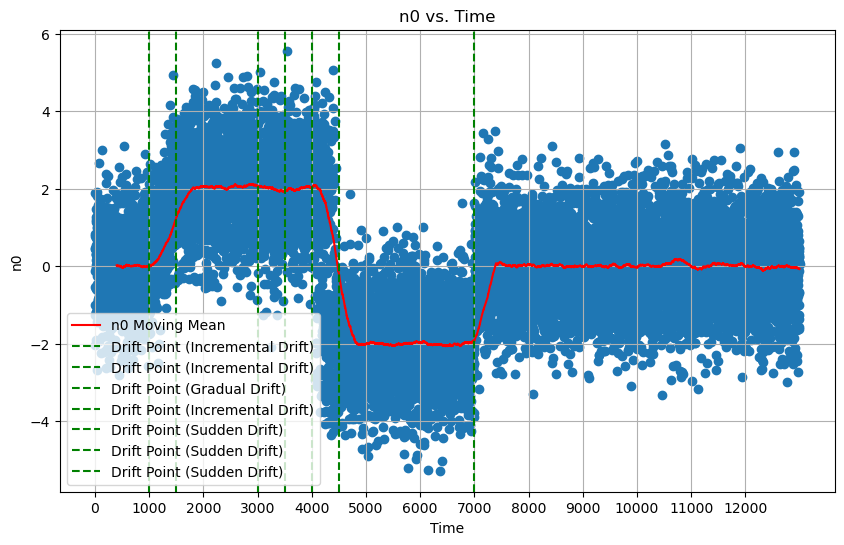

Feature: n0
Drift detected at index 1000: Incremental Drift
Drift detected at index 1500: Incremental Drift
Drift detected at index 3000: Gradual Drift
Drift detected at index 3500: Incremental Drift
Drift detected at index 4000: Sudden Drift
Drift detected at index 4500: Sudden Drift
Drift detected at index 7000: Sudden Drift


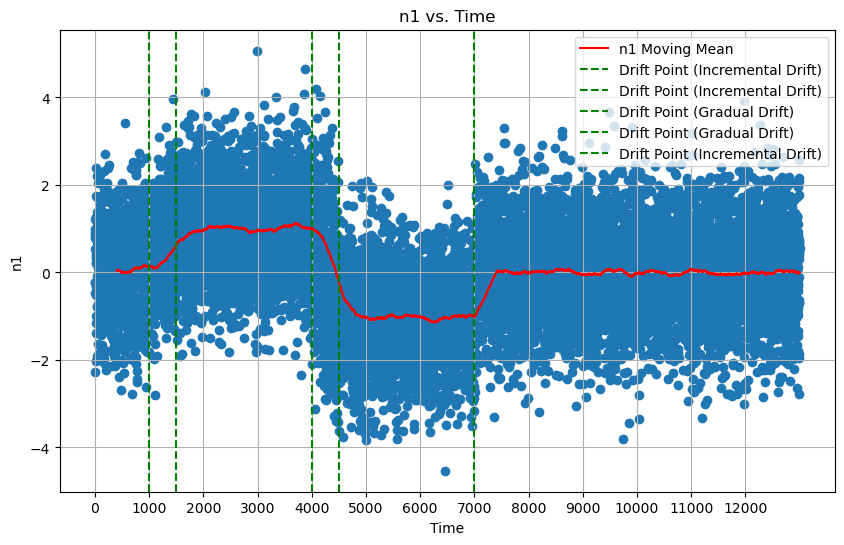

Feature: n1
Drift detected at index 1000: Incremental Drift
Drift detected at index 1500: Incremental Drift
Drift detected at index 4000: Gradual Drift
Drift detected at index 4500: Gradual Drift
Drift detected at index 7000: Incremental Drift


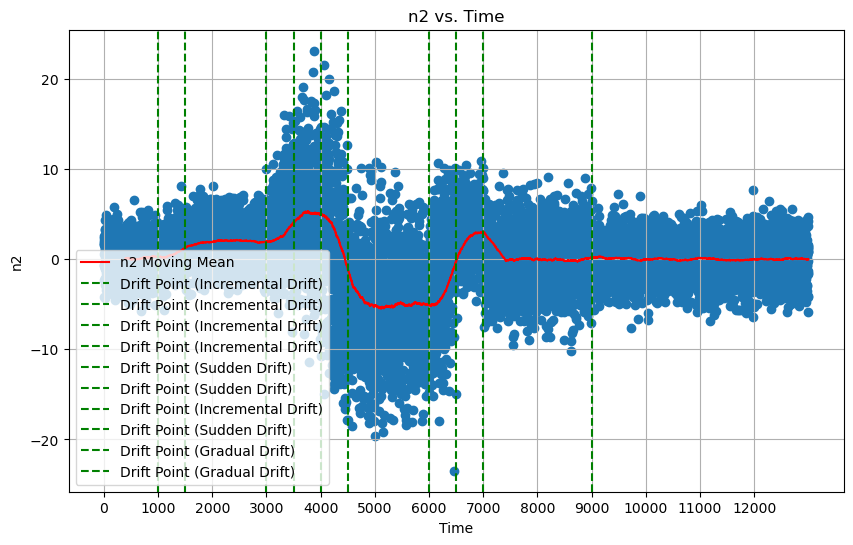

Feature: n2
Drift detected at index 1000: Incremental Drift
Drift detected at index 1500: Incremental Drift
Drift detected at index 3000: Incremental Drift
Drift detected at index 3500: Incremental Drift
Drift detected at index 4000: Sudden Drift
Drift detected at index 4500: Sudden Drift
Drift detected at index 6000: Incremental Drift
Drift detected at index 6500: Sudden Drift
Drift detected at index 7000: Gradual Drift
Drift detected at index 9000: Gradual Drift


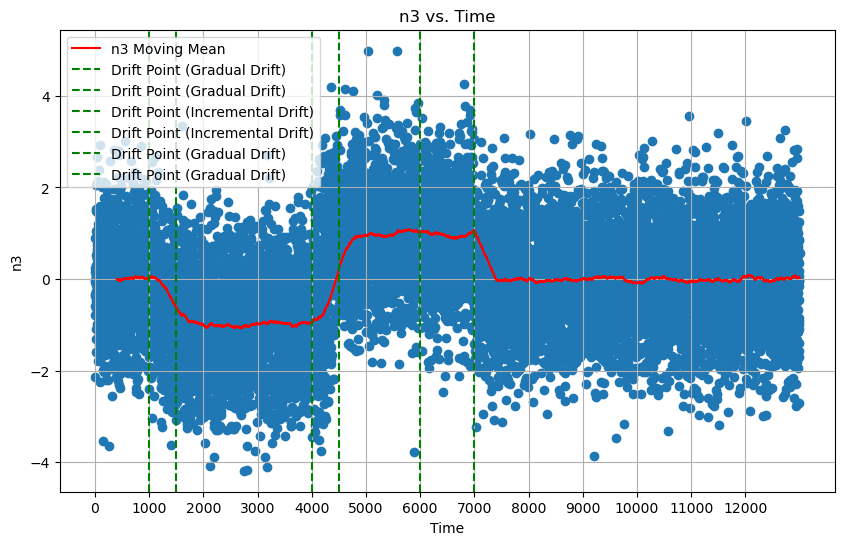

Feature: n3
Drift detected at index 1000: Gradual Drift
Drift detected at index 1500: Gradual Drift
Drift detected at index 4000: Incremental Drift
Drift detected at index 4500: Incremental Drift
Drift detected at index 6000: Gradual Drift
Drift detected at index 7000: Gradual Drift


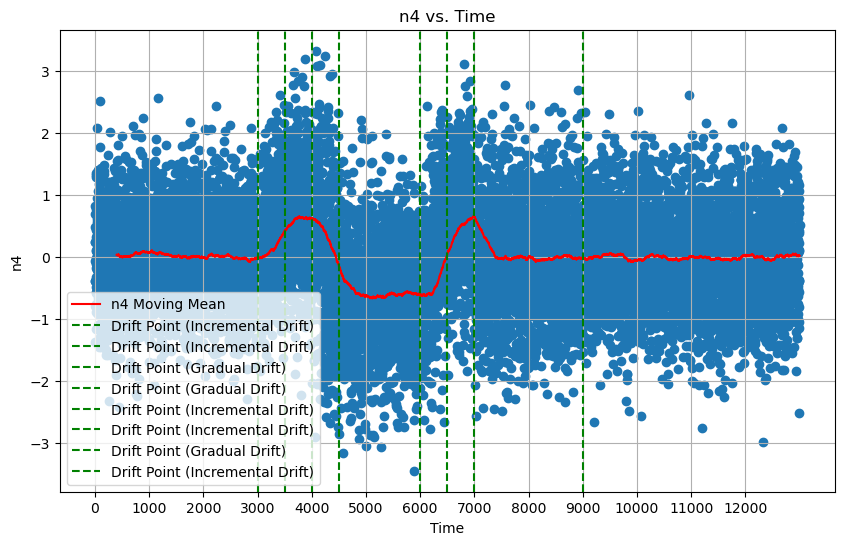

Feature: n4
Drift detected at index 3000: Incremental Drift
Drift detected at index 3500: Incremental Drift
Drift detected at index 4000: Gradual Drift
Drift detected at index 4500: Gradual Drift
Drift detected at index 6000: Incremental Drift
Drift detected at index 6500: Incremental Drift
Drift detected at index 7000: Gradual Drift
Drift detected at index 9000: Incremental Drift


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

window_size = 400
drift_detection_window = 500  # Window size for drift detection
significance_level = 0.05  # Significance level for statistical tests


def detect_drift(feature_data, window_size, drift_detection_window, significance_level):
    n = len(feature_data)
    drift_points = []
    drift_types = []

    for start in range(0, n, drift_detection_window):
        end = min(start + drift_detection_window, n)
        current_window = feature_data[start:end]

        if end + drift_detection_window <= n:
            next_window = feature_data[end : end + drift_detection_window]

            # Use the Kolmogorov-Smirnov test to compare distributions
            ks_stat, p_value = ks_2samp(current_window, next_window)

            if p_value < significance_level:
                drift_points.append(end)

                # Determine drift type
                mean_diff = np.mean(next_window) - np.mean(current_window)
                if np.abs(mean_diff) > np.std(feature_data):
                    drift_types.append("Sudden Drift")
                elif mean_diff > 0:
                    drift_types.append("Incremental Drift")
                else:
                    drift_types.append("Gradual Drift")

    return drift_points, drift_types


for feature in non_cat_columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_df.index, X_df[feature], marker="o")

    moving_mean = X_df[feature].rolling(window=window_size).mean()
    plt.plot(
        X_df.index,
        moving_mean,
        color="red",
        linestyle="-",
        label=f"{feature} Moving Mean",
    )

    drift_points, drift_types = detect_drift(
        X_df[feature], window_size, drift_detection_window, significance_level
    )

    for dp, dt in zip(drift_points, drift_types):
        plt.axvline(x=dp, color="green", linestyle="--", label=f"Drift Point ({dt})")

    plt.title(f"{feature} vs. Time")
    plt.xlabel("Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    plt.xticks(np.arange(0, len(X_df), 1000))
    plt.legend()
    plt.show()

    print(f"Feature: {feature}")
    for dp, dt in zip(drift_points, drift_types):
        print(f"Drift detected at index {dp}: {dt}")

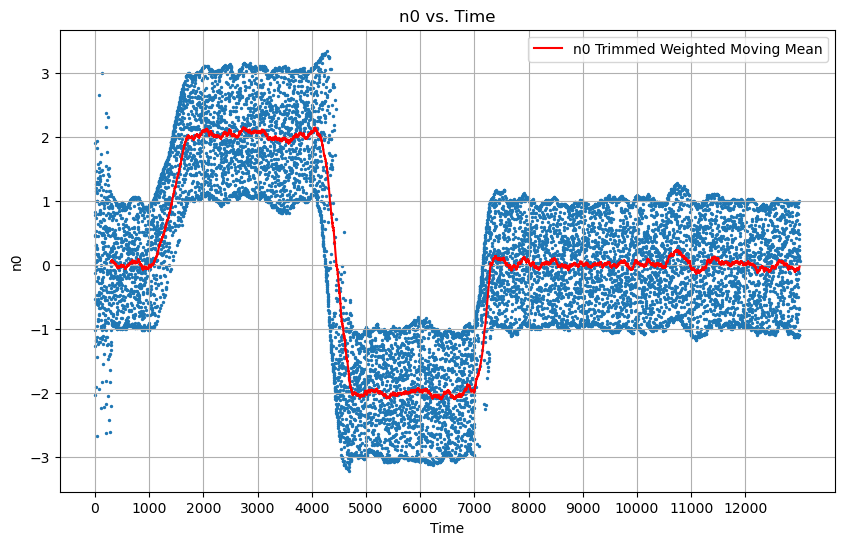

In [21]:
import numpy as np
import matplotlib.pyplot as plt

window_size = 300
d = 0.01  # Difference between consecutive weights for arithmetic scheme


def weighted_moving_average(data, weights):
    return np.convolve(data, weights / weights.sum(), mode="valid")


for feature in non_cat_columns:
    plt.figure(figsize=(10, 6))

    # Calculate the weights for the arithmetic scheme
    weights_arithmetic = np.array([1 + i * d for i in range(window_size)])

    # Calculate the weighted moving mean and std deviation
    moving_mean = weighted_moving_average(X_df[feature].values, weights_arithmetic)
    moving_std = (
        weighted_moving_average(X_df[feature].values ** 2, weights_arithmetic)
        - moving_mean**2
    )
    moving_std = np.sqrt(moving_std)

    # Trimming data to 1 std deviation within the window
    trimmed_values = X_df[feature].copy()
    for i in range(window_size, len(X_df)):
        mean = moving_mean[i - window_size]
        std = moving_std[i - window_size]
        lower_bound = mean - std
        upper_bound = mean + std
        if trimmed_values.iloc[i] < lower_bound:
            trimmed_values.iloc[i] = lower_bound
        elif trimmed_values.iloc[i] > upper_bound:
            trimmed_values.iloc[i] = upper_bound

    plt.scatter(X_df.index, trimmed_values, marker="o", s=2)
    plt.plot(
        X_df.index[window_size - 1 :],
        moving_mean,
        color="red",
        linestyle="-",
        label=f"{feature} Trimmed Weighted Moving Mean",
    )

    plt.title(f"{feature} vs. Time")
    plt.xlabel("Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    plt.xticks(np.arange(0, len(X_df), 1000))
    plt.legend()
    plt.show()
    break

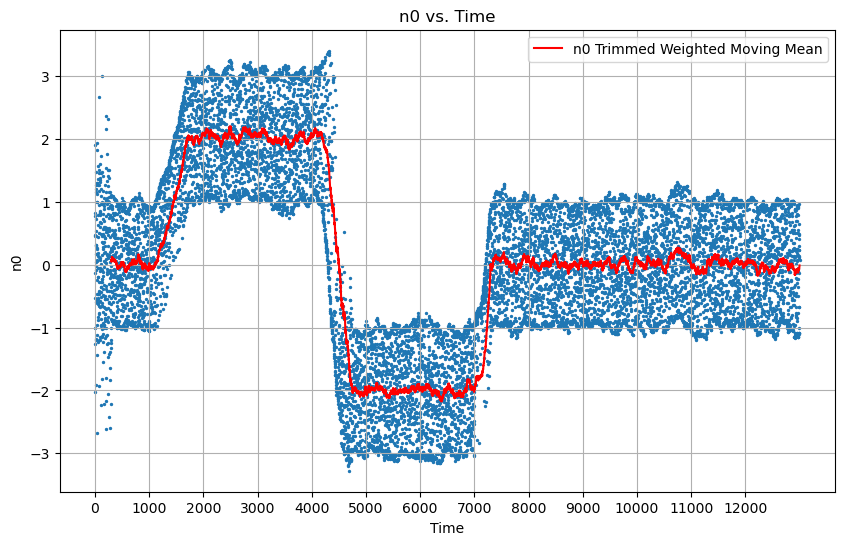

In [22]:
r = 1.01  # Ratio of two consecutive weights for geometric scheme


def weighted_moving_average_geometric(data, weights):
    return np.convolve(data, weights / weights.sum(), mode="valid")


for feature in non_cat_columns:
    plt.figure(figsize=(10, 6))

    # Calculate the weights for the geometric scheme
    weights_geometric = np.array([r**i for i in range(window_size)])

    # Calculate the weighted moving mean and std deviation
    moving_mean = weighted_moving_average_geometric(
        X_df[feature].values, weights_geometric
    )
    moving_std = (
        weighted_moving_average_geometric(X_df[feature].values ** 2, weights_geometric)
        - moving_mean**2
    )
    moving_std = np.sqrt(moving_std)

    # Trimming data to 1 std deviation within the window
    trimmed_values = X_df[feature].copy()
    for i in range(window_size, len(X_df)):
        mean = moving_mean[i - window_size]
        std = moving_std[i - window_size]
        lower_bound = mean - std
        upper_bound = mean + std
        if trimmed_values.iloc[i] < lower_bound:
            trimmed_values.iloc[i] = lower_bound
        elif trimmed_values.iloc[i] > upper_bound:
            trimmed_values.iloc[i] = upper_bound

    plt.scatter(X_df.index, trimmed_values, marker="o", s=2)
    plt.plot(
        X_df.index[window_size - 1 :],
        moving_mean,
        color="red",
        linestyle="-",
        label=f"{feature} Trimmed Weighted Moving Mean",
    )

    plt.title(f"{feature} vs. Time")
    plt.xlabel("Time")
    plt.ylabel(f"{feature}")
    plt.grid(True)
    plt.xticks(np.arange(0, len(X_df), 1000))
    plt.legend()
    plt.show()
    break

In [40]:
def trim_window_values(window, trim_stddev):
    """
    Trims the values in the window to within the specified number of standard deviations from the mean.

    Parameters:
        window (deque): The rolling window of data points.
        trim_stddev (float): The number of standard deviations to trim data points.

    Returns:
        np.array: The trimmed values.
    """
    window_mean = np.mean(window)
    window_std = np.std(window)
    lower_bound = window_mean - trim_stddev * window_std
    upper_bound = window_mean + trim_stddev * window_std

    return deque(np.clip(window, lower_bound, upper_bound), maxlen=len(window))

In [51]:
def detect_drift_using_KS(window, window_size):
    """
    Detects drift in the current window using the Kolmogorov-Smirnov test.

    Parameters:
        window (np.array): The current window of data points.
        window_size (int): The size of the rolling window.

    Returns:
        tuple: (bool, str) indicating whether drift is detected and the type of drift.
    """
    first_half = window[: window_size // 2]
    second_half = window[window_size // 2 :]
    ks_stat, p_value = ks_2samp(first_half, second_half)

    if p_value < 0.0001:
        mean_diff = np.mean(second_half) - np.mean(first_half)
        if np.abs(mean_diff) > np.std(window):
            return True, "Sudden Drift"
        elif mean_diff > 0:
            return True, "Incremental Drift"
        else:
            return True, "Gradual Drift"

    return False, None

In [52]:
def detect_feature_drift(feature_data, window_size=100, trim_stddev=1):
    """
    Detects feature drift in the given feature data using a rolling window approach.

    Parameters:
        feature_data (pd.Series): The feature data to monitor for drift.
        window_size (int): The size of the rolling window.
        trim_stddev (float): The number of standard deviations to trim data points.

    Returns:
        drift_points (list): Indices where drift is detected.
        drift_types (list): Types of drift detected at each drift point.
        moving_averages (pd.Series): Moving averages of the feature data with corresponding indices.
    """
    window_x = deque(maxlen=window_size)
    drift_points = []
    drift_types = []
    moving_avg = pd.Series(dtype=float)

    # Initialize the rolling window with the first window_size data points
    window_x.extend(feature_data.head(window_size))
    moving_avg[window_size - 1] = np.mean(window_x)

    for idx, xi in enumerate(feature_data[window_size:], start=window_size):
        # Add the new data point to the rolling window
        window_x.append(xi)

        # Trim the window values using the separate function
        # window_x = trim_window_values(window_x, trim_stddev)

        # Detect drift using the separate function
        drift_detected, drift_type = detect_drift_using_KS(
            np.array(window_x), window_size
        )

        if drift_detected:
            drift_points.append(idx)
            drift_types.append(drift_type)

        moving_avg[idx] = np.mean(window_x)

    return drift_points, drift_types, moving_avg


dp, dt, ma = detect_feature_drift(X_df["n0"])
len(dp)

42

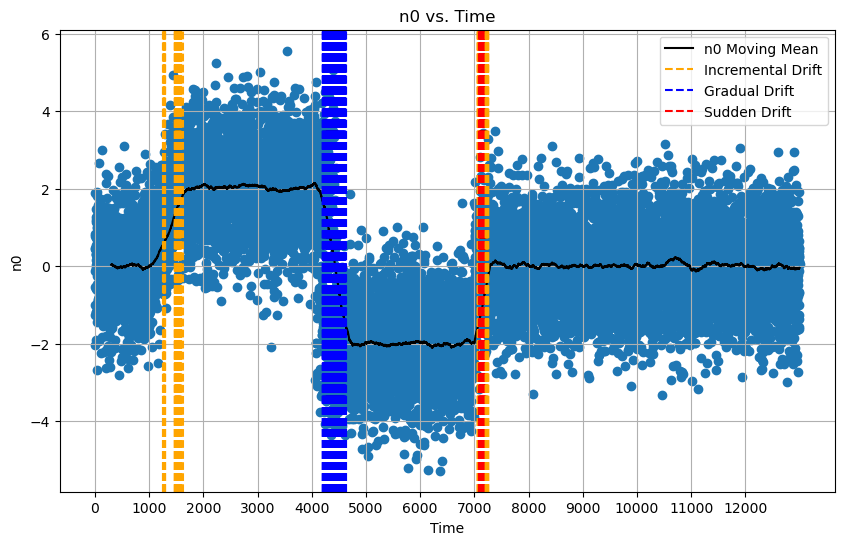

Feature: n0
Drift detected at index 1252: Incremental Drift
Drift detected at index 1253: Incremental Drift
Drift detected at index 1272: Incremental Drift
Drift detected at index 1273: Incremental Drift
Drift detected at index 1275: Incremental Drift
Drift detected at index 1276: Incremental Drift
Drift detected at index 1277: Incremental Drift
Drift detected at index 1278: Incremental Drift
Drift detected at index 1279: Incremental Drift
Drift detected at index 1280: Incremental Drift
Drift detected at index 1294: Incremental Drift
Drift detected at index 1295: Incremental Drift
Drift detected at index 1297: Incremental Drift
Drift detected at index 1299: Incremental Drift
Drift detected at index 1472: Incremental Drift
Drift detected at index 1474: Incremental Drift
Drift detected at index 1475: Incremental Drift
Drift detected at index 1477: Incremental Drift
Drift detected at index 1480: Incremental Drift
Drift detected at index 1481: Incremental Drift
Drift detected at index 1482

In [57]:
def plot_feature_drift(feature_name, feature_data):
    plt.figure(figsize=(10, 6))
    plt.scatter(feature_data.index, feature_data, marker="o")

    moving_mean = feature_data.rolling(window=window_size).mean()
    plt.plot(
        feature_data.index,
        moving_mean,
        color="black",
        linestyle="-",
        label=f"{feature} Moving Mean",
    )

    drift_points, drift_types, moving_avg = detect_feature_drift(feature_data, 300, 3)

    # plt.plot(moving_avg.index, moving_avg, color='orange', linestyle='-', label=f'{feature} Moving Mean with trimming')

    drift_type_temp_label = []
    for idx, drift_point in enumerate(drift_points):
        drift_type = drift_types[idx]
        color = (
            "red"
            if drift_type == "Sudden Drift"
            else "orange" if drift_type == "Incremental Drift" else "blue"
        )
        plt.axvline(
            x=drift_point,
            color=color,
            linestyle="--",
            label=f"{drift_type}" if drift_type not in drift_type_temp_label else "",
        )
        drift_type_temp_label.append(drift_type)

    plt.title(f"{feature_name} vs. Time")
    plt.xlabel("Time")
    plt.ylabel(f"{feature_name}")
    plt.grid(True)
    plt.xticks(np.arange(0, len(feature_data), 1000))
    plt.legend()
    plt.show()

    # print(f"Feature: {feature_name}")
    # for dp, dt in zip(drift_points, drift_types):
    #     print(f"Drift detected at index {dp}: {dt}")


plot_feature_drift("n0", X_df["n0"])